# Rider segmentation using 168 hr features

## Setup py for setting package wide global variables

In [1]:
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = 'data/'
INPUT_PATH = 'input/' # this is for afc_odx, stops, fareprod, census, geojson
FEATURE_PATH = 'cached_features/' # output of FeatureExtractor
CLUSTER_PATH = 'cached_clusters/' # output of Segmentation
PROFILE_PATH = 'cached_profiles/' # output of ClusterProfiler
VIZ_PATH = 'cached_viz/'

FEATURE_FILE_PREFIX = 'rider_features_' 
CLUSTER_FILE_PREFIX = 'rider_clusters_'
PROFILE_FILE_PREFIX = 'cluster_profiles_'

# global params for segmentation.py
ALGORITHMS = ['kmeans', 'lda']
RANDOM_STATE = 12345
MAX_ITER = 200
TOL = 1e-3

# global params for visualization.py
COLORMAP = 'Paired' # colormap

# rider type mapping for generative report
RIDER_LABEL_DICT = {
    0: 'random rider',
    1: 'weekend rider',
    2: 'normal commuter',
    3: 'early commuter',
    4: 'normal flexible commuter',
    5: 'early flexible commuter',
    6: 'weekend rider who also rides over weekdays'
}

# weekday mapping
DAY_DICT = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun',
}

# features.py

In [ ]:
import numpy as np
import pandas as pd
import sys
# import MBTASetup

class DataLoader:
    """
    NOTE:
        missing values in fareprod are filled with 'N/A' string
    """
    def __init__(self, start_month, duration):
        # initialize attributes
        self.start_month = start_month
        self.duration = duration
        self.afc_odx_fields = ['deviceclassid', 'trxtime',
                               'tickettypeid', 'card', 
                               'origin', 'movementtype']
        self.fp_fields = ['tariff', 'servicebrand', 'usertype',
                          'tickettypeid', 'zonecr']
        self.stops_fields = ['stop_id', 'zipcode']
        
        # reading in fareprod
        self.fareprod = pd.read_csv(DATA_PATH + INPUT_PATH + 'fareprod/fareprod_ttj.csv',
                                    sep=';', usecols=self.fp_fields).fillna('N/A')
        
        # reading in stops
        self.stops = pd.read_csv(DATA_PATH + INPUT_PATH + 'stops/stops_withzip.csv',
                                 sep=',', usecols=self.stops_fields, dtype={'zipcode': str})

        self.station_deviceclassid = [411, 412, 441, 442, 443, 501, 503]
        self.validation_movementtype = [7, 20]
    
    def load(self):
        self.df = pd.DataFrame()
        parse_dates = ['trxtime']

        # read in specified months of afc_odx data
        for dt in range(self.duration):
            file_key = str(int(self.start_month) + dt)
            try:
                new_df = pd.read_csv(DATA_PATH + INPUT_PATH + 'afc_odx/afc_odx_' +
                                     file_key + '.csv', sep=',', usecols=self.afc_odx_fields, dtype={'origin': str, 'card': str}, parse_dates=parse_dates)
                self.df = self.df.append(new_df)
            except FileNotFoundError:
                raise ValueError('File not found, check parameter values')

        # filter out transactions with no origin data
        self.df = self.df[-self.df['origin'].isnull()]

        # filter out station entries
        self.df = self.df[(self.df['deviceclassid'].isin(self.station_deviceclassid)) & (self.df['movementtype'].isin(self.validation_movementtype))]

        # merge afc_odx, stops and fareprod
        self.df = pd.merge(self.df, self.stops, how='inner', left_on=['origin'], right_on=['stop_id'])
        self.df = pd.merge(self.df, self.fareprod, how='inner', on='tickettypeid')

        # drop unnecessary columns
        self.df.drop(['deviceclassid', 'tickettypeid', 'origin', 'movementtype', 'stop_id'], axis=1, inplace=True)

        self.df = self.df.rename(columns={'card': 'riderID'})
        return self.df

class FeatureExtractor:
    """
    """
    def __init__(self, start_month='1701', duration=1):
        print("Loading data...", end="\r")
        sys.stdout.flush()
        self.df_transaction = DataLoader(start_month=start_month, duration=duration).load()
        self.purchase_features = ['tariff', 'usertype', 'servicebrand', 'zonecr']
        self.start_month = start_month
        self.duration = duration
        
    def _extract_temporal_patterns(self):
        """
        Function to extract rider level temporal patterns
        """
        # extract hour and day of week
        self.df_transaction['hour'] = self.df_transaction['trxtime'].apply(lambda x: x.hour)
        self.df_transaction['day_of_week'] = self.df_transaction['trxtime'].apply(lambda x: x.dayofweek)  # monday=0, sunday=6

        # counting daily pattern by rider ID
        groups = self.df_transaction.groupby(['riderID', 'day_of_week', 'hour']).agg(['count']).iloc[:, 0]
        df_group = pd.DataFrame(groups).reset_index()
        df_group.columns = ['riderID', 'day_of_week', 'hour', 'count']

        rider_id = self.df_transaction['riderID'].unique()
        N = len(rider_id)
        # construct key dataframe to merge with grouped df
        # this key_df makes sure that each rider has 168 hours
        day_id = np.array([x for x in range(0, 7)])
        day = [x for x in np.repeat(day_id, [24], axis=0)] * N
        hour = [x for x in range(0, 24)] * 7 * N
        hr_col_names = [i for i in range(1, 169)] * N
        riders = [x for x in np.repeat(rider_id, [168], axis=0)]
        key_df = pd.DataFrame(data={'riderID': riders, 'day_of_week': day, 'hour': hour, 'hr_col_names': hr_col_names})

        # left join key_df and group_df to make sure all riders have 168 hours
        # the nan's represent where the rider in df_group has no count information in that hour
        join_df = pd.merge(key_df, df_group, how='left', on=['riderID', 'day_of_week', 'hour']).replace({np.nan: 0})
        df_rider_temporal_count = join_df.pivot(index='riderID', columns='hr_col_names', values='count').reset_index()
        df_rider_temporal_count.reset_index(drop=True, inplace=True)

        # add hr_ prefix to temporal pattern
        new_col_names = [(0, 'riderID')]
        hr_col_names = [(i, 'hr_' + str(i)) for i in df_rider_temporal_count.iloc[:, 1:].columns.values]
        new_col_names.extend(hr_col_names)
        df_rider_temporal_count.rename(columns=dict(new_col_names), inplace=True)

        # add weekend vs weekday count/proportion for higher level features
        weekday_col_names = ['hr_' + str(i) for i in range(1, 121)]
        weekend_col_names = ['hr_' + str(i) for i in range(121, 169)]

        df_rider_temporal_count['weekday'] = df_rider_temporal_count[weekday_col_names].sum(axis=1)
        df_rider_temporal_count['weekend'] = df_rider_temporal_count[weekend_col_names].sum(axis=1)

        # collapse 168 hourly pattern into 24 hr weekend and 24 hr weekday (48 total) + 2 hour max 
        wkday_24_hr_col_names = ['wkday_24_' + str(i) for i in range(1, 25)]
        wkend_24_hr_col_names = ['wkend_24_' + str(i) for i in range(1, 25)]

        weekday = np.array(df_rider_temporal_count[weekday_col_names])
        weekday = weekday.reshape((len(weekday), 5, 24)).sum(axis=1)
        weekday = pd.DataFrame(weekday, columns=wkday_24_hr_col_names)

        weekend = np.array(df_rider_temporal_count[weekend_col_names])
        weekend = weekend.reshape((len(weekend), 2, 24)).sum(axis=1)
        weekend = pd.DataFrame(weekend, columns=wkend_24_hr_col_names)
        
        hr_col_names = ['hr_' + str(i) for i in range(1, 169)]
        df_rider_temporal_count = pd.concat([df_rider_temporal_count, weekday, weekend], axis=1)
        df_rider_temporal_count['hr_row_sum'] = df_rider_temporal_count[hr_col_names].iloc[:, :].sum(axis=1)
        
        df_rider_temporal_count['flex_wkday_24'] = weekday.max(axis=1).div(df_rider_temporal_count['hr_row_sum'])
        df_rider_temporal_count['flex_wkend_24'] = weekend.max(axis=1).div(df_rider_temporal_count['hr_row_sum'])
        
        # get the top 2 frequency hr in weekday
        wkday_rank = weekday.apply(np.argsort, axis=1)
        ranked_wkday_cols = weekday.columns.to_series()[wkday_rank.values[:,::-1][:,:2]]
        
        df_rider_temporal_count['max_wkday_24_1'] = pd.DataFrame(ranked_wkday_cols[:, 0])[0].apply(lambda x: str(x).split('_')[-1])
        df_rider_temporal_count['max_wkday_24_2'] = pd.DataFrame(ranked_wkday_cols[:, 1])[0].apply(lambda x: str(x).split('_')[-1])
        df_rider_temporal_count['max_wkend_24_1'] = weekend.idxmax(axis=1).apply(lambda x: x.split('_')[-1])
        
        return df_rider_temporal_count
    
    def _extract_geographical_patterns(self):
        """
        Function to extract rider level geographical patterns
        """
        # take onehot encoding of zipcodes
        onehot = pd.get_dummies(self.df_transaction['zipcode'], prefix='zipcode')
        rider_id = pd.DataFrame(data={'riderID': self.df_transaction['riderID']})
        frames = [rider_id, onehot]
        df_onehot = pd.concat(frames, axis=1)

        # count zipcodes
        df_rider_geo_count = df_onehot.groupby(['riderID'])[list(onehot.columns.values)].sum().reset_index()
        df_rider_geo_count['geo_row_sum'] = df_rider_geo_count.iloc[:, 1:].sum(axis=1)

        return df_rider_geo_count

    def _get_one_purchase_feature(self, feature):
        """
        Function to extract one purchasing feature
        """
        # take onehot encoding of the purchasing feature columns
        onehot = pd.get_dummies(self.df_transaction[feature], prefix=feature)
        rider_id = pd.DataFrame(data={'riderID': self.df_transaction['riderID']})
        frames = [rider_id, onehot]
        df_onehot = pd.concat(frames, axis=1)

        # count purchasing features
        df_onehot_count = df_onehot.groupby(['riderID'])[list(onehot.columns.values)].sum().reset_index()

        return df_onehot_count

    def _extract_ticket_purchasing_patterns(self):
        """
        Function to combine a list of rider level purchasing features
        """
        list_df_purchase_count = []
        
        for feature in self.purchase_features:
            feature_count = self._get_one_purchase_feature(feature)
            list_df_purchase_count.append(feature_count.drop(['riderID'], axis=1))
        df_purchase_count = pd.concat(list_df_purchase_count, axis=1)

        # append the riderID columns
        df_purchase_count.insert(0, 'riderID', feature_count['riderID'])
    
        return df_purchase_count
    
    def _label_rider_by_trip_frequency(self, rider):
        """
        Function to label riders by their total number of trips
        INPUT:
            rider: a row in the riders dataframe
        RETURN:
            label: a string
        """
        if rider['total_num_trips'] <= 5*self.duration:
            label = 0
        elif rider['total_num_trips'] <= 20*self.duration:
            label = 1
        elif rider['total_num_trips'] > 20*self.duration:
            label = 2
        else:
            label = -1
        return label

    def _label_commuter_rail_rider(self, rider):
        """
        Function to label riders as either commuter rail rider or others
        INPUT:
            rider: a row in the riders dataframe
        RETURN:
            label: a string, 'Commuter Rail Except Zone 1A' or 'Others'
        """
        if (rider['servicebrand_Commuter Rail'] > 0) and (rider['zonecr_1a'] == 0):
            label = 'CR except zone 1A'
        else:
            label = 'others'
        return label
    
    def extract_features(self):
        # extract time, geo and purchasing patterns
        print('Extracting temporal patterns...', end='\r')
        self.temporal_patterns = self._extract_temporal_patterns()
        sys.stdout.flush()
        print('Extracting geographical patterns...', end='\r')
        self.geographical_patterns = self._extract_geographical_patterns()
        sys.stdout.flush()
        print('Extracting purchasing patterns...', end='\r')
        self.purchasing_patterns = self._extract_ticket_purchasing_patterns()
        sys.stdout.flush()

        # merge all extracted patterns into one featues DataFrame
        self.df_rider_features = pd.merge(self.temporal_patterns, self.geographical_patterns, how='inner', on='riderID')
        self.df_rider_features = pd.merge(self.df_rider_features, self.purchasing_patterns, how='inner', on='riderID')

        # check if 'hr_row_sum' == 'geo_row_sum', they both represent total number of trips
        # if they are equal, drop one of them and rename the other to 'total_num_trips'
        if (self.df_rider_features['hr_row_sum'] == self.df_rider_features['geo_row_sum']).all():
            self.df_rider_features.drop(['hr_row_sum'], axis=1, inplace=True)
            self.df_rider_features.rename(index=str, columns={'geo_row_sum': 'total_num_trips'}, inplace=True)
        
        # drop infrequent riders
        self.df_rider_features = self.df_rider_features[self.df_rider_features['total_num_trips'] > 5*self.duration]

        
        print('Labeling riders...', end='\r')
        
        # label riders based on whether they have commuter rail pass
        self.df_rider_features['group_commuter_rail'] = self.df_rider_features.apply(self._label_commuter_rail_rider, axis=1)
        # drop CR riders
        self.df_rider_features = self.df_rider_features[self.df_rider_features['group_commuter_rail']!='CR except zone 1A']
        self.df_rider_features.drop(['group_commuter_rail'], axis=1, inplace=True)
        
        # label riders based on their usage frequency
        self.df_rider_features['group_by_frequency'] = self.df_rider_features.apply(self._label_rider_by_trip_frequency, axis=1)
        self.df_rider_features = self.df_rider_features[self.df_rider_features['group_by_frequency'].isin([1,2])]

        # drop zonecr columns (not useful)
        zonecr_cols = [col for col in self.df_rider_features.columns if 'zonecr_' in col]
        self.df_rider_features.drop(zonecr_cols, axis=1, inplace=True)
        
        
        sys.stdout.flush()
        print('Saving features..............')
        # save extracted features to cached_features directory
        self.df_rider_features.to_csv(DATA_PATH + FEATURE_PATH + FEATURE_FILE_PREFIX + 
                                      self.start_month + '_' + str(self.duration) + '.csv')

        return self.df_rider_features        


In [ ]:
# import time
# t0 = time.time()
# start_month='1710'
# duration=1
# extractor = FeatureExtractor(start_month=start_month, duration=duration).extract_features()
# print("feature extraction time: ", time.time() - t0)

## Segmentation.py

In [ ]:
# numpy == 1.14.0
# python 3.6
import pandas as pd
import numpy as np
import json
import sys, os
import time
from copy import deepcopy
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import calinski_harabaz_score


class Segmentation:
    """
    """
    def __init__(self, w_time=None, start_month='1701', duration=1, random_state=RANDOM_STATE, max_iter=MAX_ITER, tol=TOL):
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol
        
        self.start_month = start_month
        self.duration = duration
        self.w_time_choice = w_time
        
        self.__get_data()
        self.__standardize_features()
        self.__normalize_features()
        
        # number of riders
        self.N_riders = len(self.df)
        
        # feature groups
        self.time_feats = [e for e in self.df.columns if 'hr_' in e] + ['max_wkday_24_1', 'max_wkday_24_2', 'max_wkend_24_1', 'flex_wkday_24', 'flex_wkend_24']
        self.geo_feats = [e for e in self.df.columns if 'zipcode_' in e]
        self.purchase_feats = [e for e in self.df.columns if 'tariff_' in e] + [e for e in self.df.columns if 'usertype_' in e] + [e for e in self.df.columns if 'servicebrand_' in e]
        self.weekday_vs_weekend_feats = ['weekday', 'weekend']
        
        # for non hierarchical model
        self.features = self.time_feats + self.geo_feats + self.purchase_feats
        
        # for hierarchical model
        # features used in the initial round of clustering
        self.features_layer_1 = self.purchase_feats + self.weekday_vs_weekend_feats
        
        # features used in the final round of clustering
        self.features_layer_2 = self.time_feats + self.geo_feats
        
        # weights for tuning the relative importance of temporal(time) and geographical(location) patterns
        # normalized by number of columns to get equal weighting
        self.w_time = 100/len(self.time_feats) 
        self.w_geo = 100/len(self.geo_feats)
        self.w_purchase = 100/len(self.purchase_feats) # weight for purchase patterns
        self.w_week = 100/len(self.weekday_vs_weekend_feats) # weight for weekend/weekday columns
        
        
    ###############################################
    # Helper function for init constructor
    ###############################################
    def __get_data(self):
        try:
            self.df = pd.read_csv(DATA_PATH + FEATURE_PATH + FEATURE_FILE_PREFIX + self.start_month + 
                                  '_' + str(self.duration) + '.csv', sep=',', dtype={'riderID': str}, index_col=0)
        except: # if features in that month are not cached
            new_df = FeatureExtractor(start_month=self.start_month, duration=self.duration).extract_features()
            del new_df
            self.df = pd.read_csv(DATA_PATH + FEATURE_PATH + FEATURE_FILE_PREFIX + self.start_month + 
                                  '_' + str(self.duration) + '.csv', sep=',', dtype={'riderID': str}, index_col=0)
    
    def __standardize_features(self):
        # standardize features (only the columns with > 0 standard deviation)
        self.X = self.df.drop(['riderID', 'group_by_frequency'], axis=1)
        self.X_stand = pd.DataFrame()
        for col in self.X.columns:
            if self.X[col].std() == 0:
                self.X_stand[col] = 0
            else:
                self.X_stand[col] = (self.X[col] - self.X[col].mean()) / self.X[col].std()
    
    def __normalize_features(self):
        # minmax normalization (only the columns with col_max - col_min > 0)
        self.X_norm = pd.DataFrame()
        for col in self.X.columns:
            col_min = self.X[col].min()
            col_max = self.X[col].max()

            if self.X[col].max() - self.X[col].min() == 0:
                self.X_norm[col] = 0
            else:
                self.X_norm[col] = (self.X[col] - self.X[col].min()) / (self.X[col].max() - self.X[col].min())
                
    ###############################################
    # Helper function for segmentation
    ###############################################
    def __apply_clustering_algorithm(self, features, model, n_clusters_list=[2, 3, 4, 5]):
        cluster_labels_list = []
        cluster_scores = []
        
        for i, n_clust in enumerate(n_clusters_list):
            # calculate label and scores for the current set of labels
            if isinstance(model, LatentDirichletAllocation):
                model.set_params(n_components=n_clust)
                proba = model.fit_transform(features)
                cluster_labels = np.argmax(proba, axis=1)
            elif isinstance(model, KMeans):
                model.set_params(n_clusters=n_clust)
                cluster_labels = model.fit_predict(features)
            else:
                print("Algorithm not implemented")
                pass
            try:
                score = self.__get_cluster_score(features, cluster_labels)
            except:
                score = 0
            # append cluster result to list
            cluster_labels_list.append(cluster_labels)
            cluster_scores.append(score)
            print("finished fitting {}/{} models".format(i+1, len(n_clusters_list)), end='\r')
            sys.stdout.flush()
        # find the number of clusters and labels that gave the highest score
        cluster_result = cluster_labels_list[np.argmax(cluster_scores)]
        return cluster_result   
    
    def __get_cluster_score(self, features, cluster_labels):
        score = calinski_harabaz_score(features, cluster_labels)
        return score

    def __initial_rider_segmentation(self, hierarchical=False):
        '''
        Function to perform initial rider segmentation
            If sequential is True, perform Kmeans
            Otherwise, simply rename "group_by_frequency" to "initial_cluster"
        '''
        # assign initial cluster based trip frequency
        print("assigning initial clusters")
        self.df.rename(columns={"group_by_frequency": "initial_cluster"}, inplace=True)
        
        if hierarchical:
            # perform KMeans on unique clusters 
            unique_clusters = set(self.df['initial_cluster'].unique())
            
            features_to_cluster = self.X_stand.copy().loc[:, self.features_layer_1]

            # apply weights
            features_to_cluster[self.purchase_feats] = features_to_cluster[self.purchase_feats] * self.w_purchase
            features_to_cluster[self.weekday_vs_weekend_feats] = features_to_cluster[self.weekday_vs_weekend_feats] * self.w_week
        
            # perform K means clustering on the frequent riders (initial cluster = 1 or 2)
            kmeans = KMeans(random_state=self.random_state, max_iter=self.max_iter, tol=self.tol, n_jobs=-1)
            print("K means for initial clustering in hierarchical model")
            
             # loop through unique_clusters and find within-cluster clusters
            for cluster in unique_clusters:
                # find riders belonging to the current cluster
                current_X = features_to_cluster.loc[self.df['initial_cluster'] == cluster]
                new_initial_cluster = self.__apply_clustering_algorithm(current_X, kmeans, n_clusters_list=[2, 3])
               
                # update initial cluster assignment
                self.df.loc[self.df['initial_cluster']==cluster, 'initial_cluster'] = (np.array(new_initial_cluster) + (cluster * 10)).astype(int)
                del current_X
                del new_initial_cluster
            del features_to_cluster
        else:
            self.df['initial_cluster'][self.df['initial_cluster'] == 1] = 10
            self.df['initial_cluster'][self.df['initial_cluster'] == 2] = 20
        

    def __final_rider_segmentation(self, model, features, n_clusters_list=[2, 3, 4, 5], hierarchical=False):
        df = features.copy()
        # add a column
        df['final_cluster'] = np.nan
        df['initial_cluster'] = np.array(self.df['initial_cluster'])
        
        unique_clusters = set(df['initial_cluster'].unique())
        print(unique_clusters)
        features_to_cluster = None
        
        if hierarchical:
            if self.w_time_choice:
                self.w_time = self.w_time * self.w_time_choice
                self.w_geo_choice = (100 - self.w_time_choice)
                self.w_geo = self.w_geo * self.w_geo_choice
            else:
                self.w_geo_choice = None
            
            features_to_cluster = df[self.features_layer_2]
            
            # apply weights
            features_to_cluster[self.time_feats] = features_to_cluster[self.time_feats] * self.w_time
            features_to_cluster[self.geo_feats] = features_to_cluster[self.geo_feats] * self.w_geo
        else:
            # update weights
            if self.w_time_choice:
                self.w_time = self.w_time * self.w_time_choice
                self.w_geo_choice = (100 - self.w_time_choice)/2
                self.w_pur_choice = self.w_geo_choice
                self.w_geo = self.w_geo * self.w_geo_choice
                self.w_purchase = self.w_purchase * self.w_pur_choice
            else:
                self.w_geo_choice = None
                
            features_to_cluster = df[self.features]
            # apply weights
            features_to_cluster[self.purchase_feats] = features_to_cluster[self.purchase_feats] * self.w_purchase
            features_to_cluster[self.time_feats] = features_to_cluster[self.time_feats] * self.w_time
            features_to_cluster[self.geo_feats] = features_to_cluster[self.geo_feats] * self.w_geo

        # loop through unique_clusters and find within-cluster clusters
        for cluster in unique_clusters:
            # find riders belonging to the current cluster
            current_X = features_to_cluster.loc[df['initial_cluster'] == cluster]
            final_clusters = self.__apply_clustering_algorithm(current_X, model, n_clusters_list=n_clusters_list)
    
            # update initial cluster assignment
            df.loc[df['initial_cluster']==cluster, 'final_cluster'] = (np.array(final_clusters) + (cluster * 10)).astype(int)
        results = df['final_cluster']
        
        del df
        del features_to_cluster

        return results

    def get_rider_segmentation(self, hierarchical=False):
        if hierarchical:
            n_clusters_list = [2, 3, 4]
        else: 
            n_clusters_list = [i for i in range(2, 9)]
        self.scores = {}
        # perform initial segmentation
        print("performing initial segmentation...")
        self.__initial_rider_segmentation(hierarchical=hierarchical)
        
        # perform K means
        print("performing KMeans...")
        kmeans = KMeans(random_state=self.random_state, max_iter=self.max_iter, tol=self.tol, n_jobs=-1)
        self.df['kmeans'] = self.__final_rider_segmentation(kmeans, self.X_stand, n_clusters_list=n_clusters_list, hierarchical=hierarchical)
        print(self.df['kmeans'].unique())
        self.scores['kmeans'] = self.__get_cluster_score(self.X_stand, self.df['kmeans'])
        del kmeans

        # perform LDA
        print("performing LDA...")
        lda = LatentDirichletAllocation(random_state=self.random_state, n_jobs=-1)
        self.df['lda'] = self.__final_rider_segmentation(lda, self.X_norm, n_clusters_list=n_clusters_list, hierarchical=hierarchical)    
        print(self.df['lda'].unique())
        self.scores['lda'] = self.__get_cluster_score(self.X_norm, self.df['lda'])
        del lda

        print("saving results...")
        if hierarchical:
            # save results in subdirectories
            dest = DATA_PATH + CLUSTER_PATH + 'hierarchical/'
            if not os.path.isdir(dest):
                os.makedirs(dest)  
        else:
            # save results in a subdirectory
            dest = DATA_PATH + CLUSTER_PATH + 'non_hierarchical/'
            if not os.path.isdir(dest):
                os.makedirs(dest)
        
                
        if not os.path.isdir(dest+'results/'):
                os.makedirs(dest+'results/')
                
        if not os.path.isdir(dest+'scores/'):
            os.makedirs(dest+'scores/')

        if self.w_time_choice:
            self.df.to_csv(dest + 'results/'+ CLUSTER_FILE_PREFIX + self.start_month + 
                       '_' + str(self.duration) + '_' + str(self.w_time_choice) + '.csv')
            scores_json = json.dumps(self.scores)
            f = open(dest + 'scores/' + CLUSTER_FILE_PREFIX + self.start_month + 
                    '_' + str(self.duration) + '_' + str(self.w_time_choice) + '.json',"w")
            f.write(scores_json)
            f.close()
        else:
            self.df.to_csv(dest + 'results/'+ CLUSTER_FILE_PREFIX + self.start_month + '_' + str(self.duration) 
                           + '_0' + '.csv')
            scores_json = json.dumps(self.scores)
            f = open(dest + 'scores/' + CLUSTER_FILE_PREFIX + self.start_month + '_' + str(self.duration)  +
                     '_0' + '.json',"w")
            f.write(scores_json)
            f.close()    
    

In [ ]:
import time
t0 = time.time()
start_month='1702'
duration=1
segmentation = Segmentation(start_month=start_month, duration=duration)
segmentation.get_rider_segmentation(hierarchical=True)
print("Hierarchical clustering time: ", time.time() - t0)

In [ ]:
t0 = time.time()
start_month='1702'
duration=1
segmentation = Segmentation(start_month=start_month, duration=duration)
segmentation.get_rider_segmentation(hierarchical=False)
print("Non-hierarchical clustering time: ", time.time() - t0)

# Report.py

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# from MBTAriderSegmentation.config import *

class ReportGenerator():
    def __init__(self, cnn_model_filename, sample_factor=1000, noise_std=0.3):
        self.n_classes = len(RIDER_LABEL_DICT)
        self.cnn_model_filename = cnn_model_filename
        self.sample_factor = sample_factor
        self.noise_std = noise_std

    def get_text(self, row):
        text = 'Cluster {}\'s predicted type of rider is {} .'.format(row['cluster'], RIDER_LABEL_DICT[row['rider_type']])
        text += 'There are {} riders in the cluster, taking on average {} trips. '.format(row['cluster_size'],
                                                                                          round(row['cluster_avg_num_trips'], 2))
        max_wkday_1 = DAY_DICT[row['max_wkday_1']]
        max_wkday_2 = DAY_DICT[row['max_wkday_2']]
        max_wkend_1 = DAY_DICT[row['max_wkend_1']]

        max_wkday_hr1 = str(row['max_wkday_hr1'])+':00'
        max_wkday_hr2 = str(row['max_wkday_hr2'])+':00'
        max_wkend_hr1 = str(row['max_wkend_hr1'])+':00'

        text += 'The top 2 most frequent trip time during weekday is '
        text += '{} {} and {} {}. '.format(max_wkday_1, max_wkday_hr1, max_wkday_2, max_wkday_hr2)
        text += 'The top 1 most frequent trip time during weekend is {} {}. '.format(max_wkend_1, max_wkend_hr1)
        text += 'The top 1 most frequent trip origin is at zipcode {}. '.format(row['max_zip'])
        return text

    def generate_report(self, df):
        # drop the old report
        if 'report' in df.columns:
            df.drop(['report'], axis=1, inplace=True)
        if 'rider_type' in df.columns:
            df.drop(['rider_type'], axis=1, inplace=True)

        df_copy = df.copy()

        hr_cols = ['hr_' + str(i) for i in range(1, 169)]
        X_1D = df_copy[hr_cols].values
        n_clusters = X_1D.shape[0]
        X = np.expand_dims(X_1D.reshape((n_clusters, 7, 24)), axis=-1)

        self.cnn_model = load_model(self.cnn_model_filename)
        if 'manual_label' in df_copy.columns:
            y_onehot = np.eye(len(RIDER_LABEL_DICT))[df_copy['manual_label'].values.astype(int)]
            scores = self.cnn_model.evaluate(X, y_onehot, verbose=1)
            print('Loss (against manual label):', scores[0])
            print('Accuracy (against manual label):', scores[1])

        df_copy['rider_type'] = self.cnn_model.predict_classes(X)

        df_copy['max_wkday_1'] = ((df_copy['max_wkday_24_1']-1)/24).astype(int)
        df_copy['max_wkday_2'] = ((df_copy['max_wkday_24_2']-1)/24).astype(int)
        df_copy['max_wkend_1'] = ((df_copy['max_wkend_24_1']-1)/24).astype(int)

        df_copy['max_wkday_hr1'] = ((df_copy['max_wkday_24_1']-1)%24).astype(int)
        df_copy['max_wkday_hr2'] = ((df_copy['max_wkday_24_2']-1)%24).astype(int)
        df_copy['max_wkend_hr1'] = ((df_copy['max_wkend_24_1']-1)%24).astype(int)

        zip_cols = [col for col in df_copy.columns if 'zipcode_' in col]
        max_zip_indices = np.argmax(df_copy[zip_cols].values, axis=1)
        df_copy['max_zip'] = [zip_cols[idx].split('_')[-1] for idx in max_zip_indices]

        df_copy['report'] = df_copy.apply(lambda row: self.get_text(row), axis=1)

        # save the profile csv with report and newly predicted rider type
        df['rider_type'] = df_copy['rider_type']
        df['report'] = df_copy['report']
        return df


# Profile.py

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import os, sys
import re
from datetime import datetime

# from MBTAriderSegmentation.config import *
# from MBTAriderSegmentation.report import ReportGenerator

class CensusFormatter:
    """
    Class to format and to return formatted census data
    """
    # column names used to rename raw census columns
    new_col_names = [
        'zipcode', 'state',
        # Race & Ethnicity
        'race_pop_nb', 'race_wht', 'race_blk', 'race_ntv', 'race_asn',
        'race_isld', 'race_othr', 'race_two', 'race_hisp',
        # Age & Sex
        'as_pop_nb', 'as_f_br0', 'as_f_br1', 'as_f_br2', 'as_f_br3',
        'as_f_br4', 'as_f_br5', 'as_f_br6', 'as_f_br7', 'as_m_br0',
        'as_m_br1', 'as_m_br2', 'as_m_br3', 'as_m_br4', 'as_m_br5',
        'as_m_br6', 'as_m_br7',
        # Household Income in 2016 Inflation-Adjusted Dollars
        'inc_med', 'inc_hh_nb', 'inc_br0', 'inc_br1', 'inc_br2',
        'inc_br3', 'inc_br4', 'inc_br5', 'inc_br6',
        # Education Attainment
        'edu_pop_25_nb', 'edu_nd', 'edu_hs', 'edu_sc', 'edu_bd', 'edu_gd',
        # Poverty
        'pov_fam_nb', 'pov_fam_in_pov',
        # Unemployment
        'emp_pop_16_nb', 'emp_unemployed',
        # Housing units
        'hu_house_units_nb',
        # Household Statistics
        'hstat_hh_nb', 'hstat_fam',
        'hstat_mcf', 'hstat_mcf_ychild', 'hstat_mcf_nchild',
        'hstat_spf', 'hstat_spf_ychild', 'hstat_spf_nchild',
        'hstat_nf', 'hstat_nf_alone', 'hstat_nf_with_ui'
    ]
    # dictionary for census groups and prefixes in the renamed census dataframe
    census_groups = {
        'race': 'race_',
        'agesex': 'as_',
        'income': 'inc_',
        'education': 'edu_',
        'poverty': 'pov_',
        'unemployment': 'emp_',
        'housing_units': 'hu_',
        'household': 'hstat_'
    }

    def __init__(self, raw_census_filepath):
        self.raw_census_filepath = raw_census_filepath
        self.census_in_counts = self.__format_raw_census_in_counts(self.raw_census_filepath)
        self.census_in_percents = self.__convert_to_percents(self.census_in_counts)
        self.census_in_proportions = self.__convert_to_proportions(self.census_in_counts)

    def __format_raw_census_in_counts(self, raw_census_filepath):
        """
        DESCRIPTION:
            Function to unify the raw census data format.
            The raw census represents some columns in counts and others
            in percents. This function converts all data representation
            to counts. Specifically, this function formats data pertaining
            to education, poverty and unemployment.
        INPUT:
            raw_census_filepath: A string of file path to raw census data
        RETURN:
            census: A formaated dataframe where data is represented in counts
        """
        census = pd.read_excel(raw_census_filepath, skiprows=3,
                               names=CensusFormatter.new_col_names,
                               dtype={'Unnamed: 0': str})
        # add Unoccupied Housing Unit = Housing units - Households
        census['hu_occ_hh'] = census['hstat_hh_nb']
        census['hu_unocc'] = census['hu_house_units_nb'] - census['hu_occ_hh']
        census['pov_fam_not_in_pov'] = 100 - census['pov_fam_in_pov']
        census['emp_employed'] = 100 - census['emp_unemployed']

        # convert education, poverty and unemployment to numbers
        edu_cols = [col for col in census.columns if 'edu_' in col]
        pov_cols = [col for col in census.columns if 'pov_' in col]
        emp_cols = [col for col in census.columns if 'emp_' in col]

        # convert education from % to numbers
        for col in edu_cols:
            if '_pop_25' not in col:
                census[col] = (round(census[col].mul(census['edu_pop_25_nb']) / 100)).astype(int)
        # convert poverty from % to numbers
        for col in pov_cols:
            if '_fam' not in col:
                census[col] = (round(census[col].mul(census['pov_fam_nb']) / 100)).astype(int)
        # convert unemployment % to numbers
        for col in emp_cols:
            if '_pop_16' not in col:
                census[col] = (round(census[col].mul(census['emp_pop_16_nb']) / 100)).astype(int)
        return census

    def __convert_to_percents(self, census_in_counts):
        """
        DESCRIPTION:
            Function to convert counts distribution into percentages.
            The normalizing columns (e.g. populations, households and
            family units) plus inc_med (median income) are not converted.
        INPUT:
            census_in_counts: A dataframe where census data are in counts.
                This is the output of __format_raw_census_in_counts().
        RETURN:
            converted: A dataframe where census data are in percentages.
        """
        converted = census_in_counts.copy()
        # loop through each demographics profile group
        for cset, prefix in CensusFormatter.census_groups.items():
            # get the column names corresponding to current group
            cset_cols = [col for col in converted.columns if prefix in col]

            # find the normalizing column
            norm_suffix = '_nb'
            norm_col = [col for col in cset_cols if norm_suffix in col][0]

            # convert each column except the norm_col in current group
            for col in cset_cols:
                # do not normalize norm_col and inc_med (median income)
                if (col is not norm_col and '_med' not in col):
                    # normalize to percentages
                    converted[col] = (converted[col].div(converted[norm_col])).replace({np.nan: 0, np.inf: 0})
        return converted

    def __convert_to_proportions(self, census_in_counts):
        """
        DESCRIPTION:
            Function to convert counts distribution into percentages.
            The normalizing columns (e.g. populations, households and
            family units) plus inc_med (median income) are not converted.
        INPUT:
            census_in_counts: A dataframe where census data are in counts.
                This is the output of __format_raw_census_in_counts().
        RETURN:
            converted: A dataframe where census data are in proportions.
        """
        converted = census_in_counts.copy()
        # loop through each demographics profile group
        for cset, prefix in CensusFormatter.census_groups.items():
            # get the column names corresponding to current group
            cset_cols = [col for col in converted.columns if prefix in col]

            # find the normalizing column
            norm_suffix = '_nb'
            norm_col = [col for col in cset_cols if norm_suffix in col][0]

            # convert each column except the norm_col in current group
            for col in cset_cols:
                # do not normalize norm_col and inc_med (median income)
                if (col is not norm_col and '_med' not in col):
                    # normalize to proportions
                    converted[col] = converted[col].div(converted[norm_col]).replace({np.nan: 0, np.inf: 0})
        return converted

    def to_csv(self, filename, census_type='proportions'):
        """
        DESCRIPTION:
            Function to save census data in either percents or counts
        INPUT:
            filename: A string of file name to save, required
            census_type: A string of which census type to save,
                oprtions=['percents', 'counts', 'proportions'], default = 'proportions'
        RETURN:
            None
        """
        if census_type == 'proportions':
            self.census_in_proportions.to_csv(filename)
        elif census_type == 'percents':
            self.census_in_percents.to_csv(filename)
        elif census_type == 'counts':
            self.census_in_counts.to_csv(filename)
        else:
            raise ValueError('census_type must be either "percents", "counts" or "proportions"')

    def get_census_in_counts(self):
        """
        DESCRIPTION:
            Simple function that returns census_in_count
        INPUT:
            None
        RETURN:
            census_in_count: A dataframe where data is in counts
        """
        return self.census_in_counts

    def get_census_in_percents(self):
        """
        DESCRIPTION:
            Simple function that returns census_in_percent
        INPUT:
            None
        RETURN:
            census_in_percent: A dataframe where data is in percentages
        """
        return self.census_in_percents

    def get_census_in_proportions(self):
        """
        DESCRIPTION:
            Simple function that returns census_in_percent
        INPUT:
            None
        RETURN:
            census_in_percent: A dataframe where data is in properties
        """
        return self.census_in_proportions


class ClusterProfiler:
    # feature groups and expected prefixes in riders
    feat_groups = {
        'cluster': ['cluster_'],
        'temporal': ['hr_'],
        'geographical': ['zipcode_'],
        'ticket_purchase': ['usertype_', 'tariff_', 'servicebrand_']
    }

    demo_groups = {
        'cluster': 'cluster_',
        'race': 'race_',
        'agesex': 'as_',
        'income': 'inc_',
        'education': 'edu_',
        'poverty': 'pov_',
        'unemployment': 'emp_',
        'housing_units': 'hu_',
        'household': 'hstat_'
    }

    def __init__(self, hierarchical=False, w_time=None, start_month='1701', duration=1):
        self.start_month = start_month
        self.duration = duration
        self.hierarchical = hierarchical
        self.census = CensusFormatter(DATA_PATH + INPUT_PATH + "census/MA_census.xlsx").get_census_in_counts()

        if w_time:
            self.w_time = int(w_time)
        else:
            self.w_time = 0

        if hierarchical:
            self.input_path = DATA_PATH + CLUSTER_PATH + 'hierarchical/results/'
        else:
            self.input_path = DATA_PATH + CLUSTER_PATH + 'non_hierarchical/results/'

        self.param_keys = ['hierarchical', 'month', 'duration', 'w_time']

        self.__get_data()

    def __split(self, delimiters, string, maxsplit=0):
        """
        Function to split file name for matching cached results
        """
        regexPattern = '|'.join(map(re.escape, delimiters))
        return re.split(regexPattern, string, maxsplit)


    def __get_cached_params_list(self):
        """
        Function to find parameter combinations of cached results
        """
        cached_combo = []
        delimiters = ['_', '.']
        for filename in os.listdir(self.input_path):
            if filename.endswith(".csv"):
                str_split = self.__split(delimiters, filename)[:-1]
                if 'non' not in self.input_path:
                    param_vals = ['True'] + str_split[2:]
                else:
                    param_vals = ['False'] + str_split[2:]
                cached_combo.append(dict(zip(self.param_keys, param_vals)))
        return cached_combo

    def __get_data(self):
        # check if the requested data is in the cache directory ready to go
        cached_combo = self.__get_cached_params_list()
        req_param_vals = [str(self.hierarchical), self.start_month, str(self.duration), str(self.w_time)]
        req_param_dict = dict(zip(self.param_keys, req_param_vals))

        if req_param_dict in cached_combo:
            self.riders = pd.read_csv(self.input_path + CLUSTER_FILE_PREFIX +
                                       req_param_dict['month'] + '_' +
                                       req_param_dict['duration'] + '_' +
                                       req_param_dict['w_time'] +
                                       '.csv', index_col=0)
        else:  # Recluster
            segmentation = Segmentation(start_month=self.start_month, duration=self.duration, w_time=self.w_time)
            segmentation.get_rider_segmentation(hierarchical=self.hierarchical)
            del segmentation
            self.riders = pd.read_csv(self.input_path + CLUSTER_FILE_PREFIX +
                                       req_param_dict['month'] + '_' +
                                       req_param_dict['duration'] + '_' +
                                       req_param_dict['w_time'] +
                                       '.csv', index_col=0)

    def _softmax(self, df):
        exp_df = np.exp(df)
        exp_df['row_sum'] = exp_df.sum(axis=1)
        exp_df = exp_df.iloc[:,:-1].div(exp_df["row_sum"], axis=0)
        return exp_df

    def _summarize_features(self, riders, by_cluster):
        """
        DESCRIPTION:
            Function to summarize, by cluster or overall, features that were used to form the clusters.
            Approach is to turn each feature group (e.g. temporal or geographical patterns) into
            a probabiliy-like distribution. This way we can say, for instance, that the probabiliy
            of cluster 1 taking a trip in hour 3 is 0.002 or that the probability of cluster 2
            taking a trip in zipcode 02138 is 0.005, etc. Since we aim for a probability
            distribution, an important characteristic to fulfill is that the resulting columns
            belonging to a feature set (e.g. the 168 hour columns) add up to 1.
        INPUT:
            riders: A dataframe containing rider-level pattern-of-use features
                used to form clusters plus resulting cluster assignment, required
            by_cluster: A boolean, summarize features by cluster or overall, required
        RETURN:
            cluster_features: A dataframe containing cluster-level pattern-of-use features
                and additional cluster info such as cluster size
        """
        if by_cluster:
            # group by cluster and calculate cluster_size and cluster_avg_num_trips
            temp_df1 = riders.groupby(by=['cluster'])
            # column sums
            temp_df2 = temp_df1.sum()
            temp_df2['cluster_size'] = temp_df1['total_num_trips'].count()
            temp_df2['cluster_avg_num_trips'] = temp_df2['total_num_trips'].div(temp_df2['cluster_size'], axis=0)
            temp_df2 = temp_df2.reset_index()

            max_hr_modes = temp_df1.apply(lambda x: x[['max_wkday_24_1', 'max_wkday_24_2', 'max_wkend_24_1']].mode())
            max_hr_idx = [i for i, x in enumerate(max_hr_modes.index) if x[1] == 0]
            max_hr_modes = max_hr_modes.iloc[max_hr_idx].reset_index().drop(['cluster', 'level_1'], axis=1)

        else:
            temp_df1 = riders.drop(['cluster'], axis=1)
            # column sums
            temp_df2 = (temp_df1.sum().to_frame()).T
            temp_df2['cluster_size'] = len(temp_df1)
            temp_df2['cluster_avg_num_trips'] = temp_df2['total_num_trips'] / temp_df2['cluster_size']
            temp_df2 = temp_df2.reset_index().rename(index=int, columns={'index': 'cluster'})
            max_hr_modes = (temp_df1[['max_wkday_24_1', 'max_wkday_24_2', 'max_wkend_24_1']].mode().loc[0,:].to_frame()).T

        # loop through feature groups
        cluster_features = pd.DataFrame()
        cluster_features['cluster'] = temp_df2['cluster'].astype(int)
        for feature, prefix_list in ClusterProfiler.feat_groups.items():
            for prefix in prefix_list:
                # get column names that belong to the current feature group
                feature_cols = [col for col in temp_df2.columns if prefix in col]
                # normalize if the feature is not 'cluster'
                if feature is 'cluster':
                    cluster_features = pd.concat([cluster_features, temp_df2[feature_cols]], axis=1)
                else:
                    # normalize by row sum of current feature group
                    normalized = temp_df2[feature_cols].copy()
                    normalized.iloc[:, :] = (normalized.iloc[:, :].div(normalized.sum(axis=1), axis=0)).multiply(100)
                    cluster_features = pd.concat([cluster_features, normalized], axis=1)
        # add in the hr in which has the max number of trips
        cluster_features = pd.concat([cluster_features, max_hr_modes], axis=1)
        return cluster_features

    def _summarize_demographics(self, cluster_features):
        """
        DESCRIPTION:
            Function to summarize, by cluster, demographics distribution by its geo distribution.
            The approach is that for each cluster, we take its geo-pattern as a probability
            distribution over zipcodes (i.e. if cluster 1's zipcode_02142 column = 0.002, then
            0.002 is the probability/weight for zipcode 02142), and calcualte expected
            demographics distribution using zipcode probabilities. In other words, we calculate
            E = sum over i of x_i*p(x_i) where x is a vector representing demographics data in
            zipcode i and p(x_i) is the probability of zipcode i.
        INPUT:
            cluster_features: A dataframe containing cluster-level pattern-of-use features.
                This is the resulting dataframe from __get_cluster_features(), required.
        RETURN:
            cluster_demographics: A dataframe containing cluster assignment plus
                expected cluster demographics distribution. The distribution is described in
                number of people. To convert to percentages/proportions use __convert_demo_to_percent().
        """
        # get column names corresponding to geographical distribution
        geo_cols = [col for col in cluster_features.columns if 'zipcode' in col]
        geo_patterns = self._softmax(cluster_features[geo_cols])

        # filter census by the zipcodes present in the data to increase search efficiency
        self.zipcodes = [col.split('_')[-1] for col in geo_patterns.columns]
        census_of_interest = self.census.loc[self.census['zipcode'].isin(self.zipcodes)]

        cluster_demographics = pd.DataFrame()
        # loop through each cluster in geo_patterns
        for cluster, cluster_feats in geo_patterns.iterrows():
            # demographics of current cluster
            cluster_i_demo = pd.DataFrame()
            # loop through each zipcode in current cluster
            for col_name in cluster_feats.index:
                zipcode_i = col_name.split('_')[-1]  # current zipcode
                zipcode_i_prob = cluster_feats[col_name]  # weight of current zipcode
                # demographics of current zipcode
                zipcode_i_demo = census_of_interest[census_of_interest.zipcode == zipcode_i].iloc[:, 2:]
                # multiply weight by the demographics profile
                cluster_i_demo = cluster_i_demo.append(zipcode_i_prob * zipcode_i_demo)
            # cluster i demographics is weighted sum of demographics profile in each zipcode
            cluster_i_demo = cluster_i_demo.sum()
            cluster_demographics = cluster_demographics.append(cluster_i_demo.rename(cluster))

        # round all counts fields (e.g. population, num_households) as integer
        count_suffix = '_nb'
        count_cols = [col for col in cluster_demographics.columns if count_suffix in col]
        cluster_demographics[count_cols] = round(cluster_demographics[count_cols]).astype(int)

        # rename count fields with "cluster" as prefix to facilitate normalizing each individual groups
        cluster_demographics.rename(index=int, columns={"race_pop_nb": "cluster_demo_pop",
                                                        'edu_pop_25_nb': 'cluster_demo_pop_25',
                                                        'emp_pop_16_nb': 'cluster_demo_pop_16',
                                                        'inc_hh_nb': 'cluster_demo_hh',
                                                        'inc_med': 'cluster_demo_med_income',
                                                        'pov_fam_nb': 'cluster_demo_fam',
                                                        'hu_house_units_nb': 'cluster_demo_house_unit'}, inplace=True)
        # drop count columns
        new_count_cols = [col for col in cluster_demographics.columns if count_suffix in col]
        cluster_demographics.drop(new_count_cols, axis=1, inplace=True)

        # loop through feature groups
        normalized_cluster_demographics = pd.DataFrame()
        normalized_cluster_demographics['cluster'] = cluster_features['cluster']
        normalized_cluster_demographics['cluster_id'] = cluster_features['cluster'].astype(int)
        for feature, prefix in ClusterProfiler.demo_groups.items():
            # get column names that belong to the current feature group
            feature_cols = [col for col in cluster_demographics.columns if prefix in col]
            # normalize if the feature is not 'cluster'
            if feature is 'cluster':
                normalized_cluster_demographics = pd.concat([normalized_cluster_demographics, cluster_demographics[feature_cols]], axis=1)
            else:
                # normalize by row sum of current feature group
                normalized = cluster_demographics[feature_cols].copy()
                normalized.iloc[:, :] = (normalized.iloc[:, :].div(normalized.sum(axis=1), axis=0)).multiply(100)
                normalized_cluster_demographics = pd.concat([normalized_cluster_demographics, normalized], axis=1)

        return normalized_cluster_demographics

    def _get_first_2_pca_components(self, features):
        if len(features) > 1:
            X = pd.DataFrame()
            # standardize features for pca
            for col in features.drop(['cluster'], axis=1).columns:
                if features[col].std() == 0:
                    X[col] = 0
                else:
                    X[col] = (features[col] - features[col].mean())/features[col].std()
            pca = PCA(n_components=2, svd_solver='full')
            X_pca = pca.fit_transform(X)
            pca_df = pd.DataFrame(data={'cluster': features['cluster'], 'viz_id': features['cluster'].astype(int),
                                        'viz_pca1': X_pca[:, 0], 'viz_pca2': X_pca[:, 1],
                                        'viz_size': features['cluster_size'], 'viz_grp': features['cluster'] // 100})
        else: # there is only one cluster
            pca_df = pd.DataFrame(data={'cluster': features['cluster'], 'viz_id': features['cluster'].astype(int),
                                        'viz_pca1': 0, 'viz_pca2': 0,
                                        'viz_size': features['cluster_size'], 'viz_grp': 0})
        return pca_df

    def extract_profile(self, algorithm, by_cluster):
        """
        DESCRIPTION:
            Function to extract cluster profile.
        INPUT:
            by_cluster: A boolean indicating whether feature summary should be performed by cluster, required
        RETURN:
            profile: A dataframe with cluster assignment, features and demographics distribution
        """

        cols_to_drop = ['riderID', 'initial_cluster']
        df = self.riders.drop(ALGORITHMS + cols_to_drop, axis=1)
        df['cluster'] = self.riders[algorithm]

        # summarize features
        if by_cluster:
            print("summarizing by cluster features...")
            self.features = self._summarize_features(df, True)
        else:
            print("summarizing overall features...")
            self.features = self._summarize_features(df, False)

        # summarize demographics
        print("summarizing demographics...")
        self.demographics = self._summarize_demographics(self.features)

        # get pca components
        print("getting pcas...")
        pca_df = self._get_first_2_pca_components(self.features)

        # merge dfs
        profile = self.features.merge(self.demographics, on='cluster', how='inner')
        profile = profile.merge(pca_df, on='cluster', how='inner')

        # generating reports
        print("generating reports...")
        cnn_model_filename = DATA_PATH + REPORT_PATH + 'report_cnn.h5'
        profile = ReportGenerator(cnn_model_filename=cnn_model_filename).generate_report(profile)

        print("saving results...")
        self.__save_profile(profile, algorithm, by_cluster)

    def __save_profile(self, profile, algorithm, by_cluster):
        start_month = datetime.strptime(self.start_month, "%y%m").strftime("%Y-%b")

        if self.duration > 1:
            end_month = datetime.strptime(str(int(self.start_month) + self.duration-1), "%y%m").strftime("%Y-%b")
            dest = DATA_PATH + PROFILE_PATH + start_month + '_to_' + end_month + '/'
        else:
            dest = DATA_PATH + PROFILE_PATH + start_month + '/'

        if not os.path.isdir(dest):
            os.makedirs(dest)

        if by_cluster:
            if self.hierarchical:
                profile.to_csv(dest + 'hierarchical_' + PROFILE_FILE_PREFIX  + self.start_month +
                       '_' + str(self.duration) + '_' + str(self.w_time) + '_' + algorithm + '.csv')
            else:
                profile.to_csv(dest + 'non-hierarchical_' + PROFILE_FILE_PREFIX  + self.start_month +
                       '_' + str(self.duration) + '_' + str(self.w_time) + '_' + algorithm + '.csv')

        else:
            profile.to_csv(dest + 'overview_' + PROFILE_FILE_PREFIX  + self.start_month +
                       '_' + str(self.duration) + '.csv')


In [7]:
import time
t0 = time.time()
start_month='1710'
duration=1

profiler = ClusterProfiler(start_month=start_month, duration=duration, hierarchical=True)
profiler.extract_profile(algorithm='kmeans', by_cluster=False)
print("Cluster Profiling time: ", time.time() - t0)

summarizing overall features...
summarizing demographics...
getting pcas...
saving results...


# Visualization.py

In [5]:
from sklearn.decomposition import PCA
from datetime import datetime
import os
import re
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from branca.colormap import linear
import IPython

# from MBTAriderSegmentation.config import *
# from MBTAriderSegmentation.profile import ClusterProfiler

SMALL_FONT = 12
MEDIUM_FONT = 15
LARGE_FONT = 100

sns.set()
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_FONT)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT)  # fontsize of the figure title

class Visualization:
    def __init__(self, start_month='1701', duration=1):
        self.start_month = start_month
        self.duration = duration

        # setting the file path based on start month and duration
        start = datetime.strptime(self.start_month, "%y%m").strftime("%Y-%b")
        if self.duration > 1:
            end = datetime.strptime(str(int(self.start_month) + self.duration-1), "%y%m").strftime("%Y-%b")
            self.input_path = DATA_PATH + PROFILE_PATH + start + '_to_' + end + '/'
            self.output_path = DATA_PATH + VIZ_PATH + start + '_to_' + end + '/'
        else:
            self.input_path = DATA_PATH + PROFILE_PATH + start + '/'
            self.output_path = DATA_PATH + VIZ_PATH + start + '/'

        if not os.path.isdir(self.input_path):
            os.makedirs(self.input_path)

        self.param_keys = ['view', 'month', 'duration', 'w_time', 'algorithm']

    def __split(self, delimiters, string, maxsplit=0):
        """
        Function to split file name for matching cached results
        """
        regexPattern = '|'.join(map(re.escape, delimiters))
        return re.split(regexPattern, string, maxsplit)

    def __get_cached_params_list(self):
        """
        Function to find parameter combinations of cached results
        """
        cached_combo = []
        delimiters = ['_', '.']
        for filename in os.listdir(self.input_path):
            if filename.endswith(".csv"):
                str_split = self.__split(delimiters, filename)[:-1]
                if len(str_split) > 5:
                    param_vals = [str_split[0]] + str_split[3:]
                else:
                    param_vals = [str_split[0]] + str_split[3:5] + ['na', 'na']
                cached_combo.append(dict(zip(self.param_keys, param_vals)))
        return cached_combo

    def __read_csv(self, req_param_dict, by_cluster):
        if by_cluster:
            self.df = pd.read_csv(self.input_path + req_param_dict['view'] + '_' +
                                      PROFILE_FILE_PREFIX +
                                       req_param_dict['month'] + '_' +
                                       req_param_dict['duration'] + '_' +
                                       req_param_dict['w_time'] + '_' +
                                       req_param_dict['algorithm'] +
                                       '.csv', index_col=0)
        else:
            self.df = pd.read_csv(self.input_path + req_param_dict['view'] + '_' +
                                      PROFILE_FILE_PREFIX +
                                       req_param_dict['month'] + '_' +
                                       req_param_dict['duration'] +
                                       '.csv', index_col=0)


    def load_data(self, by_cluster=False, hierarchical=False, w_time=None, algorithm=None):
        # check if the requested data is in the cache directory ready to go
        cached_combo = self.__get_cached_params_list()
        if by_cluster:
            # parse hierarchical request
            if hierarchical:
                self.req_view = 'hierarchical'
            else:
                self.req_view = 'non-hierarchical'

            # parse w_time request
            if not w_time:
                self.req_w_time = str(0)
            else:
                self.req_w_time = str(w_time)

            # parse algo request
            if not algorithm:
                self.req_algo = 'kmeans'
            else:
                self.req_algo = algorithm

        else:
            self.req_view = 'overview'
            self.req_w_time = 'na'
            self.req_algo = 'na'

        req_param_vals = [self.req_view, self.start_month, str(self.duration), self.req_w_time, self.req_algo]
        req_param_dict = dict(zip(self.param_keys, req_param_vals))

        # check if request params are cached in profiler
        if req_param_dict in cached_combo:
            self.__read_csv(req_param_dict, by_cluster)
        else:  # Get the cluster profile again
            profiler = ClusterProfiler(hierarchical=hierarchical, w_time=w_time, start_month=self.start_month, duration=self.duration)
            profiler.extract_profile(algorithm=algorithm, by_cluster=by_cluster)
            del profiler
            self.__read_csv(req_param_dict, by_cluster)


    def visualize_clusters_2d(self):
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        for grp in self.df.viz_grp.unique():
            if grp == 1:
                grp_label = '<= 20 Trips/Month'
            else:
                grp_label = '> 20 Trips/Month'
            ax.scatter(x=self.df[self.df.viz_grp == grp].viz_pca1,
                       y=self.df[self.df.viz_grp == grp].viz_pca2,
                       s=self.df[self.df.viz_grp == grp].viz_size/100,
                       label='{} Groups'.format(grp_label),
                       alpha=0.5)
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_title('Clusters visualized on PCA axes')

        lgnd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        # change the marker size manually for both lines
        for handle in lgnd.legendHandles:
            handle._sizes = [300]
        plt.show()

    def plot_cluster_hourly_pattern(self, cluster):
        time_feats = [col for col in self.df.columns if 'hr_' in col]
        heatmap_matrix = self.df.loc[self.df['cluster'] == cluster, time_feats].values.reshape(7, 24)
        fig, ax = plt.subplots(1, 1, figsize = (18, 4))
        ax.set_title('{} - cluster {}'.format(self.req_algo, cluster))
        ax.set_xlabel('Hours in the day')
        ax.set_ylabel('Day of week')
        sns.heatmap(heatmap_matrix,
                    yticklabels=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'],
                    cmap="YlGnBu", ax=ax)
        plt.show()

    def plot_all_hourly_patterns(self):
        for i, cluster in self.df.iterrows():
            self.plot_cluster_hourly_pattern(cluster.cluster)

    def plot_cluster_geo_pattern(self, cluster):
        geo_cols = [col for col in self.df.columns if 'zipcode' in col]
        zipcodes = [z.split('_')[-1] for z in geo_cols]
        geo_json_data = json.load(open(DATA_PATH + INPUT_PATH + 'geojson/ma_massachusetts_zip_codes_geo.min.json'))
        filtered_geo_json = [d for d in geo_json_data['features'] if d['properties']['ZCTA5CE10'] in zipcodes]
        geo_json_data['features'] = filtered_geo_json

        data = self.df.loc[self.df['cluster']==cluster, geo_cols].T
        data['zipcodes'] = zipcodes
        # rename columns and check if geopattern is successfully extracted
        try:
            data.columns = ["geopattern", "zipcodes"]
        except ValueError:
            raise ValueError("Check cluster ID. The unique cluster IDs are {}".format(self.df['cluster'].unique()))

        colormap = linear.YlGnBu.scale(data.geopattern.min(), data.geopattern.max())
        data_dict = data.set_index('zipcodes')['geopattern']


        # initialize map
        m = folium.Map([42.34, -71.1], zoom_start=9.5)

        # plot geo data
        folium.GeoJson(
            geo_json_data,
            style_function=lambda feature: {
                'fillColor': colormap(data_dict[feature['properties']['ZCTA5CE10']]),
                'color': 'black',
                'weight': 1,
                'dashArray': '5, 5',
                'fillOpacity': 0.9,
            }
        ).add_to(m)

        # add colormap and legend
        colormap.caption = 'Trip Origin Density (%)'
        colormap.add_to(m)

        # save visualization
        output_filename = 'GEO-chart' + '_' + self.req_view + '_' + self.start_month + '_' + str(self.duration) + '_' + self.req_w_time + '_' + self.req_algo + '_cluster'+ str(cluster) + '.html'
        if not os.path.isdir(self.output_path):
            os.makedirs(self.output_path)
        m.save(os.path.join(self.output_path + output_filename))

        # display
        url = self.output_path + output_filename
        return url

    def __single_feature_viz(self, feature, title, ylabel, xlabel):
        '''
        Single-bar plot visualization of cluster_feat VS. cluster #
        cluster_feat: ['cluster_size', 'cluster_avg_num_trips']
        '''
        ax = self.df.set_index('cluster')[[feature]].plot(kind='bar', rot=0,
                                                                  title=title,
                                                                  figsize=(10, 7), colormap=COLORMAP)
        ax.legend_.remove()
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        plt.show()

    def plot_cluster_size(self):
        if self.req_view == 'overview':
            title = 'Overview \n Number of Riders'
            xlabel = 'overview'
        else:
            title = self.req_view.upper() + '\nCluster Size'
            xlabel = 'Cluster ID'
        self.__single_feature_viz('cluster_size', title=title, ylabel='Number of riders', xlabel=xlabel)

    def plot_avg_num_trips(self):
        if self.req_view == 'overview':
            title = 'Overview \n Average # of Trips'
            xlabel = 'Overview'
        else:
            title = self.req_view.upper() + '\nAverage # of Trips'
            xlabel = 'Cluster ID'
        self.__single_feature_viz('cluster_avg_num_trips', title=title, ylabel='Avg # of Trips', xlabel=xlabel)

    def __group_feature_viz(self, grp_key, stacked, title, ylabel, xlabel):
        '''
        Multi-bar plot visualization of cluster_feat VS. cluster #
        cluster_feat_key: String, in ['servicebrand', 'usertype', 'tariff',
                                        'race', 'emp', 'edu', 'inc']
        stacked: boolean, default = True for stacked bar plot; False for side-by-side bar plot
        '''
        key = grp_key + '_'
        feat_grps = [col for col in self.df.columns if key in col]
        ax = self.df.set_index('cluster')[feat_grps].plot(kind='bar', rot=0, stacked=stacked,
                                                             title=title,
                                                             legend=False, figsize=(10, 7), colormap=COLORMAP)
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        plt.show()

    def plot_demographics(self, grp, stacked=True):
        """
        grp: ['race', 'emp', 'edu', 'inc']
        """
        if grp not in ['race', 'emp', 'edu', 'inc']:
            raise ValueError("Not a type of ticket purchasing field. Options=['race', 'emp', 'edu', 'inc']")

        if self.req_view == 'overview':
            title_dict = {
                'race': 'Overview \n Race',
                'emp': 'Overview \n Unemployment',
                'edu': 'Overview \n Education',
                'inc': 'Overview \n Income'
            }
            xlabel='Overview'
        else:
            title_dict = {
                'race': self.req_view.upper() + '\n Race',
                'emp': self.req_view.upper() + '\n Unemployment',
                'edu': self.req_view.upper() + '\n Education',
                'inc': self.req_view.upper() + '\n Income'
            }
            xlabel='Cluster ID'

        self.__group_feature_viz(grp, stacked=stacked, title=title_dict[grp], ylabel='% Rider', xlabel=xlabel)

    def plot_ticket_purchasing_patterns(self, grp, stacked=True):
        """
        grp: ['servicebrand', 'usertype', 'tariff']
        """
        if grp not in ['servicebrand', 'usertype', 'tariff']:
            raise ValueError("Not a type of ticket purchasing field. Options=['servicebrand', 'usertype', 'tariff']")

        if self.req_view == 'overview':
            title_dict = {
                'servicebrand': 'Overview \n Servicebrand',
                'usertype': 'Overview \n User Type',
                'tariff': 'Overview \n Tariff Type'
            }
            xlabel='Overview'
        else:
            title_dict = {
                'servicebrand': self.req_view.upper() + '\n Servicebrand',
                'usertype': self.req_view.upper() + '\n User Type',
                'tariff': self.req_view.upper() + '\n Tariff Type'
            }
            xlabel='Cluster ID'

        self.__group_feature_viz(grp, stacked=stacked, title=title_dict[grp], ylabel='% Rider', xlabel=xlabel)


In [6]:
start_month='1710'
duration=1
viz = Visualization(start_month=start_month, duration=duration)
viz.load_data(by_cluster=True, hierarchical=False, w_time=None, algorithm='lda')

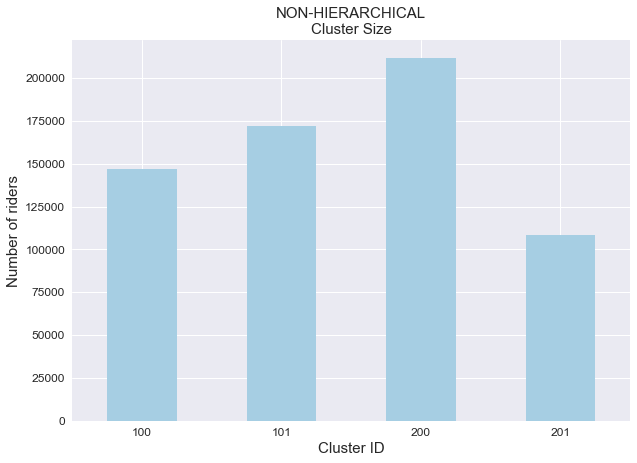

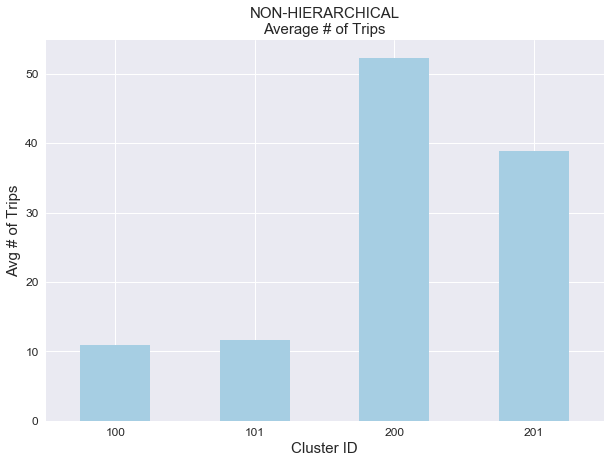

In [7]:
viz.plot_cluster_size()
viz.plot_avg_num_trips()

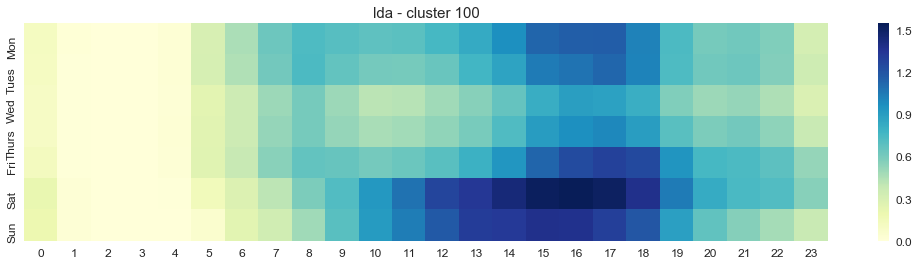

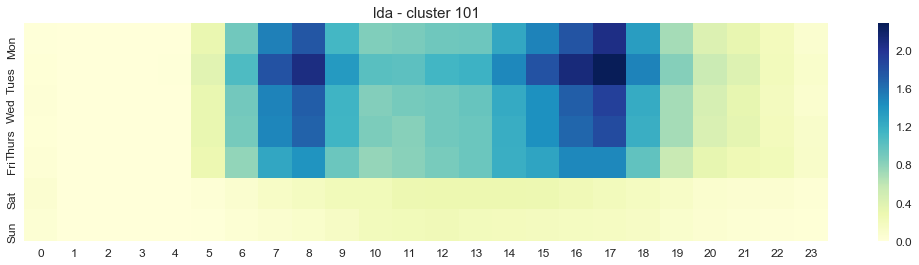

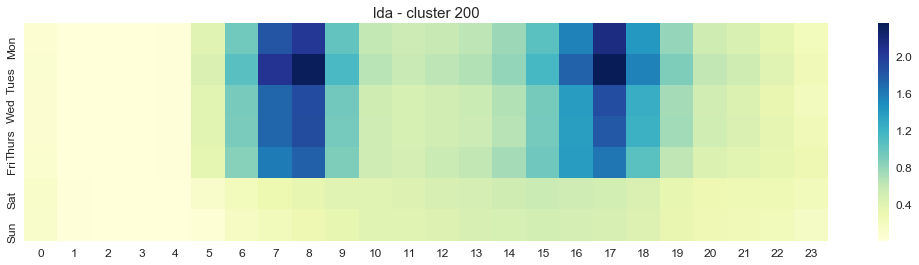

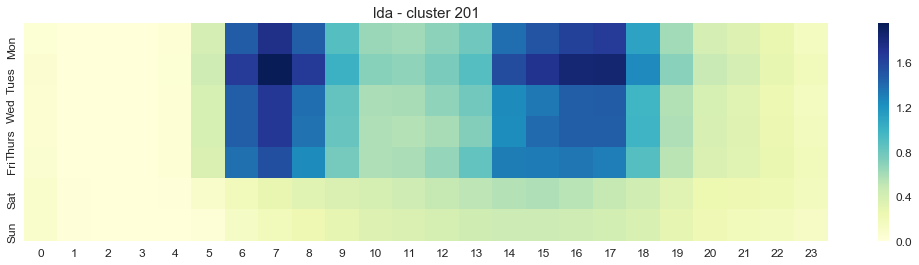

In [8]:
viz.plot_all_hourly_patterns()

In [ ]:
unique_clusters = list(viz.df['cluster'].unique())
map_urls = []
for cluster in unique_clusters:
    map_urls.append(viz.plot_cluster_geo_pattern(cluster))
map_urls 

In [ ]:
url = 'data/cached_viz/2017-Oct/GEO-chart_hierarchical_1710_1_0_lda_cluster110.html'
iframe = '<iframe src=' + url + ' width=550 height=650></iframe>'
IPython.display.HTML(iframe)

In [ ]:
url =  'data/cached_viz/2017-Oct/GEO-chart_hierarchical_1710_1_0_lda_cluster110.html'
iframe = '<iframe src=' + url + ' width=550 height=650></iframe>'
IPython.display.HTML(iframe)